In [1]:
%matplotlib inline

import sys, os, time
#from pathlib import Path
#from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import numpy as np
#!pip install fabio
import fabio
import pyFAI
import h5py
from glob import glob

from matplotlib.colors import LogNorm, SymLogNorm
from matplotlib.backend_tools import Cursors
#from matplotlib.widgets import Cursor

import ipywidgets as widgets
from IPython.display import clear_output

In [2]:
filepath = os.getcwd()
filepath

'/gpfs/offline1/visitors/formax/20240661/2024102408/process'

In [5]:
scannumber = 20
filename = 'scan_{:06d}_pilatus.hdf5'.format(scannumber)
samplename = 'B1LecMx2-10-film'
with h5py.File(os.path.dirname(filepath)+'/raw/{}/{:06d}.h5'.format(samplename, scannumber), 'r') as f:
    dy = len(f['/entry/measurement/sy'])
with h5py.File(filepath+'/frameprocessing/{}/{}'.format(samplename, filename), 'r') as f:
    data = np.sum(f['I'], axis=1)/np.count_nonzero(f['I'], axis=1)
    data = data.reshape(dy, len(data)//dy, 1024)
    print('image size is ({}, {})'.format(dy, len(data)//dy))
    q = f['q'][:]
    azi = f['phi'][:]

image size is (101, 1)


/tmp/ipykernel_195/1110748043.py:7: RuntimeWarning: invalid value encountered in true_divide
  data = np.sum(f['I'], axis=1)/np.count_nonzero(f['I'], axis=1)


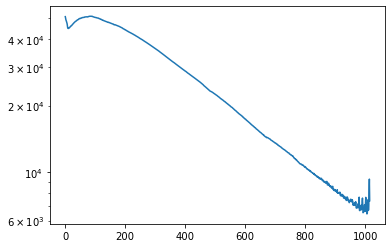

In [14]:
plt.semilogy(data.sum(axis=(0,1)))

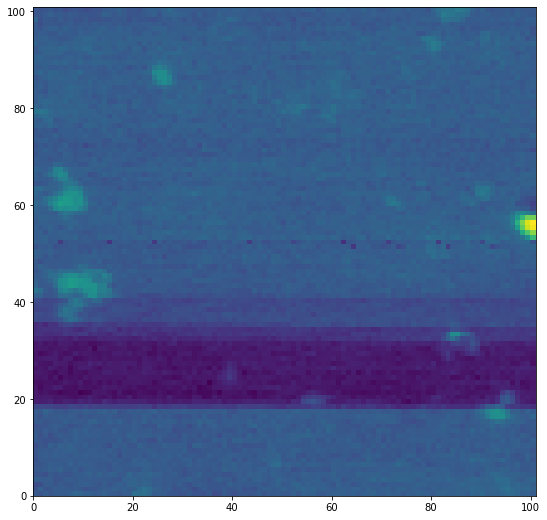

In [15]:
fig, ax = plt.subplots(1,1, figsize=(9,9))
plt.pcolormesh(data[:,:,200:600].sum(axis=2))
plt.show()

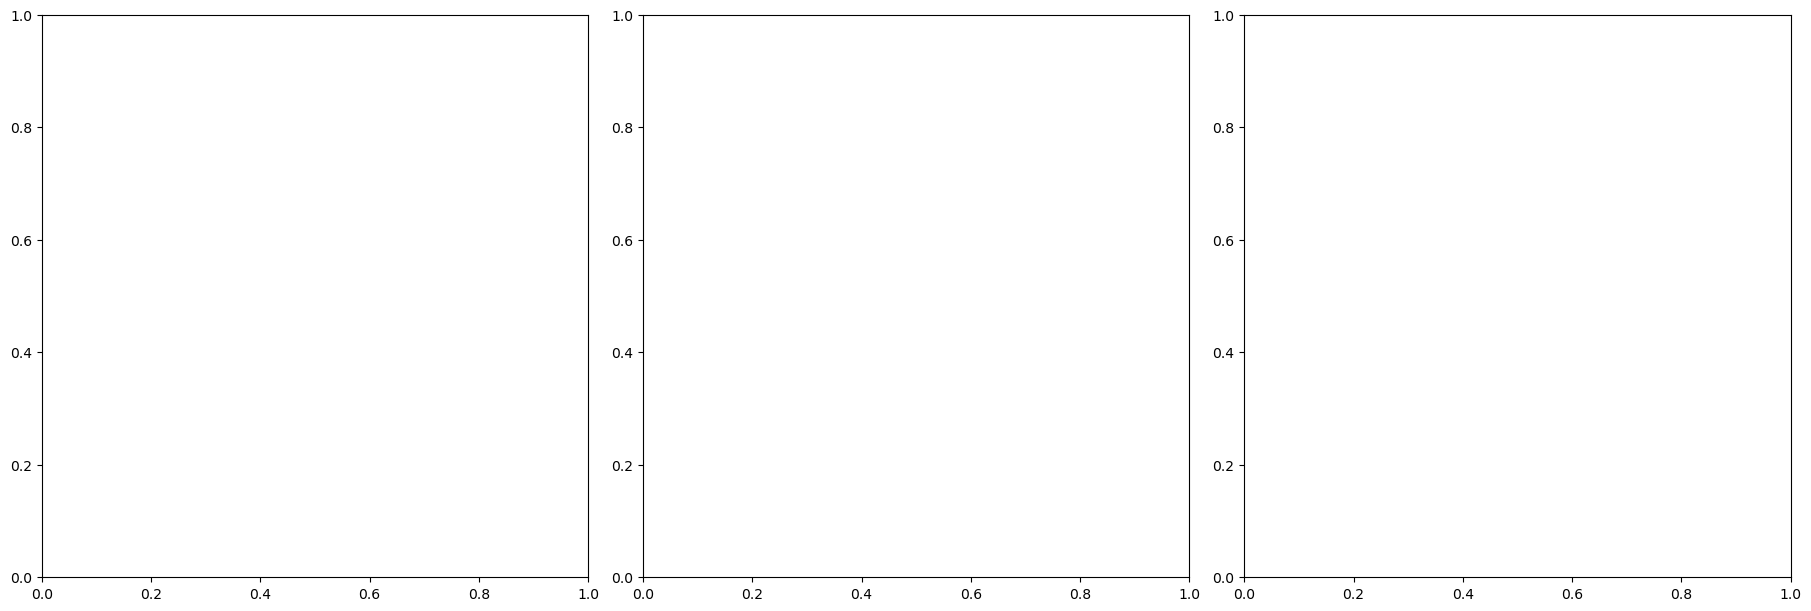

In [4]:
#clear_output(wait=False)
filelist = widgets.Dropdown(
    options=[(os.path.basename(x), x) for x in sorted(glob(filepath+'/Reshaped/**/Re*.h5', recursive=True))],
    #value='2',
    description='File:',
    disabled=False,
)

x = widgets.IntSlider(
    value = 15,
    min = 0,
    max = 30,
    description='y range:',
    disabled=False,
    continuous_update=False,
)

y = widgets.IntSlider(
    value = 15,
    min = 0,
    max = 30,
    description='x range:',
    disabled=False,
    continuous_update=False,
)

q = widgets.IntRangeSlider(
    value=[300, 1000],
    min=0,
    max=1023,
    step=1,
    description='Q range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

theta = widgets.IntRangeSlider(
    value=[2, 285],
    min=0,
    max=360,
    description = 'Azimuthal:',
    disabled=False,
    continuous_update=False
)

def g(file):
    rawfilename = os.path.basename(os.path.dirname(file))+'/'+ os.path.basename(file)[5:11]
    #print(rawfilename)
    with h5py.File(os.path.dirname(filepath)+'/raw/{}.h5'.format(rawfilename), 'r') as f:
        dy = len(f['/entry/measurement/sy'])
        y = len(f['/entry/measurement/pseudo/y'])
        x.max = dy
        y.max = y//dy
    
widgets.interactive_output(g, {'file': filelist})

def f(file, q, x, y, theta):
    #clear_output(wait=False)
    #print(file)
    data = h5py.File(file, 'r')['I']
    w = h5py.File(file, 'r')['q'][:]
    azi = h5py.File(file, 'r')['azi'][:]
    rawfilename = os.path.basename(os.path.dirname(file))+'/'+ os.path.basename(file)[5:11]
    #print(rawfilename)
    #with h5py.File(os.path.dirname(filepath)+'/raw/{}.h5'.format(rawfilename), 'r') as f:
    #    dy = len(f['/entry/measurement/sy'])

    #data = data.reshape(dy, len(data)//dy, 360, 1024)
    
    fig, axs0 = plt.subplots(1, 3, constrained_layout=True, figsize= (18,6))

    axs0[0].pcolormesh(np.sum(data[:,:,theta[0]:theta[1], q[0]:q[1]], axis=(2,3)), norm=LogNorm(), shading='auto')
    #cursor = Cursor(axs0[0], useblit=True, color='red', linewidth=2)
    axs0[0].axhline(x, color='k')
    axs0[0].axvline(y, color='r')
    axs0[1].semilogy(w, np.sum(data[x,y,theta[0]:theta[1],:], axis=0)/np.count_nonzero(data[x,y,theta[0]:theta[1],:], axis=0), '-')
    axs0[1].axvline(w[q[0]], color='k')
    axs0[1].axvline(w[q[1]], color='r')
    axs0[2].plot(azi,np.mean(data[x,y,:,q[0]:q[1]], axis=1), '-')
    axs0[2].axvline(azi[theta[0]])
    axs0[2].axvline(azi[theta[1]], color='r')

    fig.suptitle(os.path.basename(file))
    plt.show()

out = widgets.interactive_output(f, {'file': filelist, 'q': q, 'x': x, 'y': y, 'theta': theta})
UI = widgets.VBox([filelist, q, y, x, theta])

display(UI, out)
clear_output(wait=True)

In [51]:
for file in options:
    rawfilename = os.path.basename(os.path.dirname(file))+'/'+ os.path.basename(file)[5:11]
    with h5py.File(file, 'r') as i:
        data = i['I']
        w = i['q']
        azi = i['phi']
        print(rawfilename)
        try:
            #with h5py.File(os.path.dirname(filepath)+'/raw/{}.h5'.format(rawfilename), 'r') as f:
            #    dy = len(f['/entry/measurement/sy'])
            with h5py.File(filepath+'/Reshaped/{}.h5'.format(rawfilename),'r+') as g:
                g.create_dataset('q', data = w)
                g.create_dataset('azi', data = azi)

        except Exception as e:
            print(e)
            pass

A1_Al_ref/000007
[Errno 2] Unable to open file (unable to open file: name = '/data/proprietary/nanomax/20220801/2022101908/process/Reshaped/A1_Al_ref/000007.h5', errno = 2, error message = 'No such file or directory', flags = 1, o_flags = 2)
A1_Al_ref/000008
A1_Al_ref/000009
Unable to open file (file is already open for read-only)
A1_Al_ref/000010
Unable to create dataset (name already exists)
A1_Al_ref/000011
Unable to create dataset (name already exists)
A1_Al_ref/000012
Unable to create dataset (name already exists)
A1_Al_ref/000013
Unable to create dataset (name already exists)
A2_LecMx2-10/000014
Unable to create dataset (name already exists)
A2_LecMx2-10/000015
Unable to create dataset (name already exists)
A2_LecMx2-10/000016
Unable to create dataset (name already exists)
A2_LecMx2-10/000018
Unable to create dataset (name already exists)
B1LecMx2-10-film/000020
Unable to create dataset (name already exists)
B1LecMx2-10-film/000021
Unable to create dataset (name already exists)
B

In [25]:
for file in glob(filepath+'/Reshaped/C1*/00*h5', recursive=True):

    with h5py.File(file, 'r') as raw:
        print(os.path.basename(file)+' is opened')
        data = raw['I']
        ind = np.indices(data.shape[:-2])
        ind_list = np.ravel_multi_index(ind, data.shape[:-2])
        savefilename = os.path.split(file)[0]+'/Int_'+os.path.basename(file)
        with h5py.File(savefilename, "w") as savefile:
            print('intgrated file is created')
            nxdata_2d = savefile.create_dataset(u"I", data.shape[:-2]+ (1, 1024,), dtype=np.float64, shuffle=True)
            
            for index, counter in np.ndenumerate(ind_list):
                nxdata_2d[index] = np.sum(data[index], axis=0)/np.count_nonzero(data[index], axis=0)
            savefile.create_dataset('q', data=raw['q'])
            print('file is properly saved')
        print(os.path.basename(file)+' is converted and closed')

000024.h5 is opened
intgrated file is created


/tmp/ipykernel_74/4075994299.py:14: RuntimeWarning: invalid value encountered in true_divide
  nxdata_2d[index] = np.sum(data[index], axis=0)/np.count_nonzero(data[index], axis=0)


file is properly saved
000024.h5 is converted and closed


In [59]:
for file in glob(filepath+'/Reshaped/**/Int*h5', recursive=True):
    try:
        with h5py.File(file, 'r') as raw:
            print(os.path.basename(file)+' is opened')
            data = raw['I'][:]
            data = np.swapaxes(data, 0,1)
            data = data.reshape(data.shape[0], data.shape[1], 1024)
            for rawfile in glob(os.path.dirname(filepath)+'/raw/**/'+os.path.basename(file)[4:], recursive=True):
                with h5py.File(rawfile,'r') as rdata:
                    flux = rdata['/entry/measurement/alba2/1'][:]
                    #flux = np.swapaxes(flux, 0,1)
            data = data/flux[:,:,np.newaxis]
            allInt = np.mean(data, axis=(0,1))
            ind = np.indices(data.shape[:-2])
            ind_list = np.ravel_multi_index(ind, data.shape[:-2])
            savefilename = os.path.split(file)[0]+'/Reshape_Int_'+os.path.basename(file)
            with h5py.File(savefilename, "w") as savefile:
                print('intgrated file is created')
                nxdata_2d = savefile.create_dataset(u"I", data = data, dtype=np.float64, shuffle=True)    
                Intall = savefile.create_dataset('I_all', data = allInt)
                savefile.create_dataset('submean', data = np.abs(data-allInt[np.newaxis, np.newaxis, :]))
                savefile.create_dataset('q', data=raw['q'])
                print('file is properly saved')
            print(os.path.basename(file)+' is converted and closed')
    except Exception as e:
        print(e)
        pass

Int_000022.h5 is opened
intgrated file is created
file is properly saved
Int_000022.h5 is converted and closed
Int_000023.h5 is opened
intgrated file is created
file is properly saved
Int_000023.h5 is converted and closed
Int_000016.h5 is opened
operands could not be broadcast together with shapes (117,6,1024) (6,101,1) 
Int_000018.h5 is opened
intgrated file is created
file is properly saved
Int_000018.h5 is converted and closed
Int_000015.h5 is opened
intgrated file is created
file is properly saved
Int_000015.h5 is converted and closed
Int_000014.h5 is opened
operands could not be broadcast together with shapes (101,51,1024) (51,101,1) 
Int_000024.h5 is opened
intgrated file is created
file is properly saved
Int_000024.h5 is converted and closed
Int_000011.h5 is opened
operands could not be broadcast together with shapes (101,51,1024) (51,101,1) 
Int_000013.h5 is opened
operands could not be broadcast together with shapes (101,51,1024) (51,101,1) 
Int_000008.h5 is opened
intgrated f

Output()

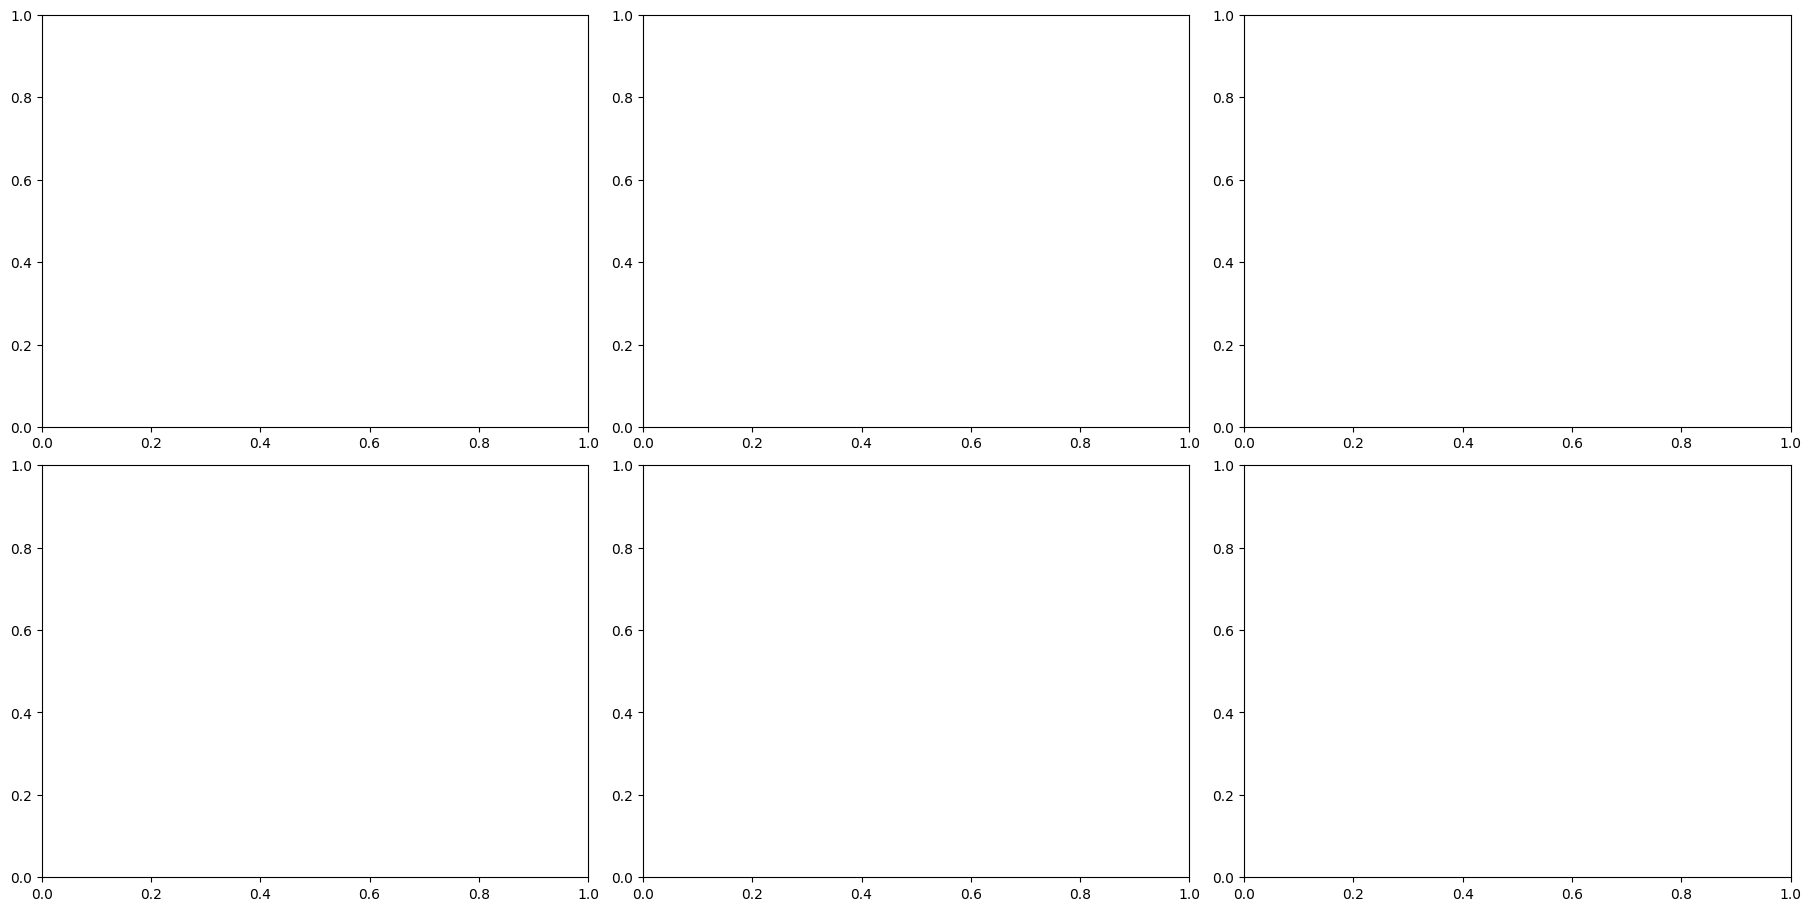

In [3]:
#clear_output(wait=False)
filelist = widgets.Dropdown(
    options=[(os.path.basename(x), x) for x in sorted(glob(filepath+'/Reshaped/**/Re*.h5', recursive=True))],
    #value='2',
    description='File:',
    disabled=False,
)

x = widgets.IntSlider(
    value = 15,
    min = 0,
    max = 30,
    description='y range:',
    disabled=False,
    continuous_update=False,
)

y = widgets.IntSlider(
    value = 15,
    min = 0,
    max = 30,
    description='x range:',
    disabled=False,
    continuous_update=False,
)

q = widgets.IntRangeSlider(
    value=[300, 1000],
    min=0,
    max=1023,
    step=1,
    description='Q range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

def g(file):
    #rawfilename = os.path.basename(os.path.dirname(file))+'/'+ os.path.basename(file)[5:11]
    #print(rawfilename)
    #with h5py.File(os.path.dirname(filepath)+'/raw/{}.h5'.format(rawfilename), 'r') as f:
    #    dy = len(f['/entry/measurement/sy'])
    #    y = len(f['/entry/measurement/pseudo/y'])
    f = h5py.File(file, 'r')
    x.max = f['I'].shape[0]-1
    y.max = f['I'].shape[1]-1
    
widgets.interactive_output(g, {'file': filelist})

def f(file, q, x, y):
    #clear_output(wait=False)
    #print(file)
    fig, axs0 = plt.subplots(2, 3, constrained_layout=True, figsize= (18,9))
    with h5py.File(file, 'r') as Re:
        data = Re['I']
        I = Re['I_all'][:]
        w = Re['q'][:]
        for xrffile in glob(filepath+'/xrf/**/*elements*{}'.format(os.path.basename(file)[16:]), recursive=True):
            xrf = h5py.File(xrffile, 'r')
            #print(xrf.keys()[0])
            Ti = xrf[os.path.basename(xrffile)[:-3].replace('_elements','')+'/xrf_fit/results/parameters/Ti_K']
            Fe = xrf[os.path.basename(xrffile)[:-3].replace('_elements','')+'/xrf_fit/results/parameters/Fe_K']
            Mn = xrf[os.path.basename(xrffile)[:-3].replace('_elements','')+'/xrf_fit/results/parameters/Mn_K']
        #x.max = data.shape[0]
        #y.max = data.shape[1]
        #azi = h5py.File(file, 'r')['azi'][:]
        #rawfilename = os.path.basename(os.path.dirname(file))+'/'+ os.path.basename(file)[5:11]
        #print(rawfilename)
        #with h5py.File(os.path.dirname(filepath)+'/raw/{}.h5'.format(rawfilename), 'r') as f:
        #    dy = len(f['/entry/measurement/sy'])

        #data = data.reshape(dy, len(data)//dy, 360, 1024)



        axs0[0,0].pcolormesh(np.sum(data[:,:,q[0]:q[1]], axis=-1), norm=LogNorm(), shading='auto')
        #cursor = Cursor(axs0[0], useblit=True, color='red', linewidth=2)
        axs0[0,0].axhline(x, color='k')
        axs0[0,0].axvline(y, color='r')
        axs0[0,1].semilogy(w, data[x,y,:], '-')
        axs0[0,1].axvline(w[q[0]], color='k')
        axs0[0,1].axvline(w[q[1]], color='r')
        axs0[0,2].plot(w,I, '-')
        axs0[0,2].axvline(w[q[0]], color='k')
        axs0[0,2].axvline(w[q[1]], color='r')
        #axs0[0,2].pcolormesh(data[:,y,:]-I,norm=LogNorm())
        #axs0[0,2].axvline(q[0], color='k')
        #axs0[0,2].axvline(q[1], color='r')
        axs0[1,0].pcolormesh(Ti)
        axs0[1,0].axhline(x, color='k')
        axs0[1,0].axvline(y, color='r')
        axs0[1,1].pcolormesh(Fe)
        axs0[1,1].axhline(x, color='k')
        axs0[1,1].axvline(y, color='r')
        axs0[1,2].pcolormesh(Mn)
        #axs0[1,2].annotate('Mn')
        
        fig.suptitle(os.path.basename(file))
        plt.show()

out = widgets.interactive_output(f, {'file': filelist, 'q': q, 'x': x, 'y': y})
UI = widgets.VBox([filelist, q, y, x])

display(UI, out)
#clear_output(wait=True)

In [5]:
Elements = ['Si', 'Ti', 'Fe', 'Mn', 'Cr']
for file in glob(filepath+'/xrf/**/B3*elements*22.h5', recursive=True):
    with h5py.File(file,'r') as rawfile:
        imag = rawfile['/B3LecClMx50-10-film_000022/xrf_fit/results/parameters']
        for key in imag.keys():
            if 'errors' not in key:
                
        


<KeysViewHDF5 ['Al_K', 'Al_K_errors', 'Ar_K', 'Ar_K_errors', 'Ca_K', 'Ca_K_errors', 'Cl_K', 'Cl_K_errors', 'Cr_K', 'Cr_K_errors', 'Fe_K', 'Fe_K_errors', 'Mn_K', 'Mn_K_errors', 'S_K', 'S_K_errors', 'Si_K', 'Si_K_errors', 'Ti_K', 'Ti_K_errors']>


In [44]:
os.path.basename(xrffile)[:-2].replace('_elements','')

NameError: name 'xrffile' is not defined